# PNN for particle detection in HEP

In [1]:
# standard python libraries for data maniipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

Classification of signal events to background events with different particle masses.

## 0) 2d gaussian events
2d gaussian distributions at different $\mu$

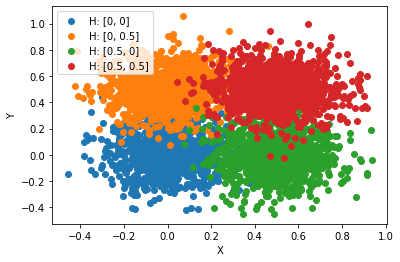

In [2]:
np.random.seed(42)
sizes = 1000
signals = [[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5]]
cov = np.array([[0.02, 0],[0, 0.02]])
labels = ["[0, 0]", "[0, 0.5]", "[0.5, 0]", "[0.5, 0.5]"]
data = [np.random.multivariate_normal(signal, cov, size=sizes) for signal in signals]
for idx, d in enumerate(data):
    plt.scatter(d[:, 0], d[:, 1], label=f"H: {labels[idx]}")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## 1) Create custom dataset for training the PNN

In [3]:
# torch library for machine learning and utilities for data generating process
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset


In [4]:
class CustomDataset(Dataset):
    def __init__(self, xy_range_lower: float = 0.0,
                       xy_range_upper: float = 1.0,
                       trained_params: int = 10,
                       cov = np.array([[0.02, 0],[0, 0.02]]),
                       data_points: int = 1000,
                       total_generations: int = 10000):
        """Generates data for NN training. Output is the parameterized data
        X and the labels Y per dataset index. 

        Args:
            xy_range_lower (float, optional): Lower border of data training for both dimensions. Defaults to 0.0.
            xy_range_upper (float, optional): Upper border of data training for both dimensions. Defaults to 1.0.
            trained_params (int, optional): Devides range from lower to upper bound into equal segments to 
            improve scaling performance on the training range. The square of this argument are the possible positions of the hypothesis. Defaults to 8.
            cov (_type_, optional): Covariance of the 2d gaussians. Defaults to np.array([[0.02, 0],[0, 0.02]]).
            data_points (int, optional): Amount of data points generated per each event. Defaults to 1000.
            total_generations (int, optional): Amount of events that the NN is trained on. Defaults to 10000.
        """
        
        # seeding for ensuring to always generate the same data
        np.random.seed(42)

        # default class variables
        self.xy_range_lower = xy_range_lower
        self.xy_range_upper = xy_range_upper
        self.trained_params = trained_params
        self.cov = cov
        self.data_points = data_points
        self.total_generations = total_generations

        # hypothesis
        hypothesis = np.linspace(start=self.xy_range_lower,
                                 stop=self.xy_range_upper,
                                 num=self.trained_params)
        

        # empty dataset holding the generations of events
        self.dataset = {}
        
        # vector that contains the targets for binary classification (0,...,0,1,...,1) and transform to tensor
        Y = np.concatenate([np.zeros(self.data_points), np.ones(self.data_points)])
        Y = torch.tensor(Y, requires_grad=True).float()

        # iterating over amount of generations and storing
        # converted tensors in dataset
        for gen_idx in range(self.total_generations):

            # empty vector that holds the data from the events from one generation (x, H_bg, H_signal)
            X = np.zeros(shape=(self.data_points * 2, 6))

            # random selection of hypothesis
            background, signal = np.random.choice(hypothesis,4).reshape(2, 2)

            # randomly generated gaussian curves for background and different signals
            X[:self.data_points, 0:2] = np.random.multivariate_normal(background, self.cov, size = self.data_points)
            X[self.data_points:, 0:2] = np.random.multivariate_normal(signal, self.cov, size = self.data_points)
            X[:, 2:4] = np.multiply(np.ones((self.data_points * 2, 2)), background)
            X[:, 4:6] = np.multiply(np.ones((self.data_points * 2, 2)), signal)


            # make tensors
            X = torch.tensor(X, requires_grad=True).float()
            Y = torch.tensor(Y, requires_grad=True).float()

            self.dataset[gen_idx] = (X, Y)

    def __len__(self):
        return self.total_generations # len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1]

Generate the data.

In [5]:
custom_ds = CustomDataset()
custom_dl = DataLoader(custom_ds, batch_size=10, shuffle=True)

/var/folders/0m/2px4t5jj7zb9t33jz6srvdb00000gn/T/ipykernel_1447/3887671911.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, requires_grad=True).float()


Example of dataset event.

In [6]:
# custom_ds[0]

## 2) Construct NN Network with extra input feature 

In [7]:
# torch functionalities for NN designing
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class ParameterizedNeuralNet(pl.LightningModule):
    def __init__(self):
        """Neural Network parameterized with hypothesis of signal and background
        means.
        """
        super().__init__()
        self.losses = []
        self.net = nn.Sequential(nn.Linear(in_features=6, out_features=20),
                                 nn.PReLU(),
                                 nn.Linear(in_features=20, out_features=20),
                                 nn.PReLU(),
                                 nn.Linear(in_features=20, out_features=20),
                                 nn.PReLU(),
                                 nn.Linear(in_features=20, out_features=20),
                                 nn.PReLU(),
                                 nn.Linear(in_features=20, out_features=1),
                                 nn.Sigmoid())
    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optim  = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optim

    def training_step(self, train_batch, batch_idx):
        X, Y = train_batch
        Y_hat = self.net(X)
        loss = F.binary_cross_entropy(torch.squeeze(Y_hat, -1), Y)
        self.losses.append(loss.detach().numpy())
        self.log("train_loss", loss)
        return loss

## 3) Train the NN

In [9]:
# initalilizing the model
model = ParameterizedNeuralNet()

# initializing the trainer
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=10)

# train the model on the dataset
trainer.fit(model, custom_dl)

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: 

Training: 0it [00:00, ?it/s]

### Save model after training

In [10]:
#working with directories
import os

# save the trained model
# path to save parameters from training
PATH = os.getcwd() + "/tmp/PNN_2d.pth"
if not os.path.exists(os.path.dirname(PATH)):
    os.mkdir(os.path.dirname(PATH))

torch.save(model.state_dict(), PATH)
print(f"Saved the model dictionary under {PATH}. Exiting.")

Saved the model dictionary under /Users/leonrenn/Documents/Studies/Physics/Physics Master/Semester 3/Proseminar/datascience_seminar/ParameterizedNeuralNetwork/tmp/PNN_2d.pth. Exiting.


## 4) Loss of the training

Visualization of training process.

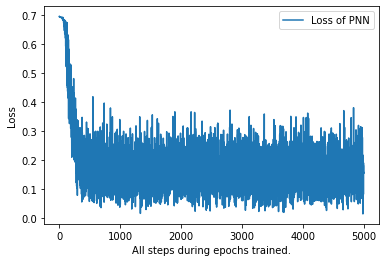

In [11]:
losses = np.asarray(model.losses)
losses.shape


plt.plot(np.arange(0,losses.shape[0]), losses, label="Loss of PNN")
plt.xlabel("All steps during epochs trained.")
plt.ylabel("Loss")
plt.legend()

## 5) Test some examples of PNN

Visualization of different mass hypotheses plotted against different masses.

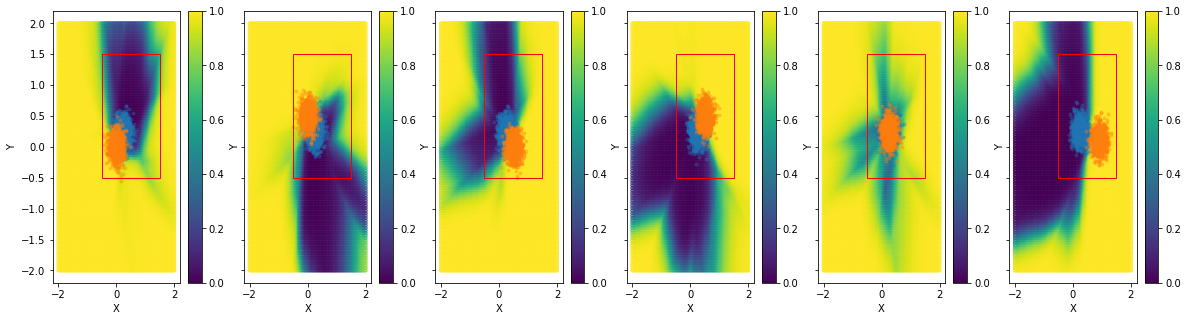

In [15]:
# generating the coordinate system
x_data = np.linspace(-2, 2, 100)
y_data = np.linspace(-2, 2, 100)
coordinates = np.array([[x, y] for x in x_data for y in y_data])

# choosing the background to be at [1,1]
bg_mean = [0.25, 0.25]
background = np.multiply(np.ones_like(coordinates), np.array(bg_mean))
data = np.zeros((100**2, 6))

# defining the plots
fig, axes = plt.subplots(ncols=len(signals), sharey=True)
fig.set_figheight(5)
fig.set_figwidth(20)

signals = [[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5], [0.25, 0.25], [0.9, 0.1]]

# rectangle to mark region of parameterization
rects = [patches.Rectangle((-0.5, -0.5), 2.0, 2.0, linewidth=1, edgecolor="red", facecolor='none') for _ in range(len(signals))]

# iterating through the signals

for signal_idx, signal in enumerate(signals):
    data[:, 0:2] = coordinates
    data[:, 2:4] = background
    data[:, 4:6] = np.multiply(np.ones_like(coordinates), np.array(signal))

    res = model(torch.Tensor(data)).detach().numpy()


    pl = axes[signal_idx].scatter(coordinates[:,0],coordinates[:,1], marker = '.', facecolor = 'none', edgecolor = plt.get_cmap('viridis')(res))
    example = [np.random.multivariate_normal(bg_mean, cov, size=sizes), np.random.multivariate_normal(signal, cov, size=sizes)]
    axes[signal_idx].scatter(example[0][:,0], example[0][:, 1], marker=".", alpha=0.3)
    axes[signal_idx].scatter(example[1][:,0], example[1][:, 1], marker=".", alpha=0.3)
    axes[signal_idx].add_patch(rects[signal_idx])
    axes[signal_idx].set_xlabel("X")
    axes[signal_idx].set_ylabel("Y")
    plt.colorbar(pl, ax=axes[signal_idx])
plt.show()
# TODO: Make plot interactive


## 6) Loading the model

In [13]:
# path to file
PATH: str = "/tmp/PNN_2d.pth"

# load model from 
model = ParameterizedNeuralNet()
PNN_state_dict = torch.load(os.getcwd() + PATH)
model.load_state_dict(PNN_state_dict)

<All keys matched successfully>